<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

Generative adversarial networks (GANs) are powerful models that learn to produce realistic objects, which are difficult to distinguish from existing real ones. They are particularly well known for their ability to produce realistic human faces. 

Below, you can see the outputs of two well-known GANs: StyleGAN2 and BigGAN (in ML, developers of particularly successful models give them names!) 

Note that in the top row, one of the images has a defect, which s very typical for GANs. You won't see these defects online too often, so I have left it here on purpose so you can see what the actual output of this model looks like.

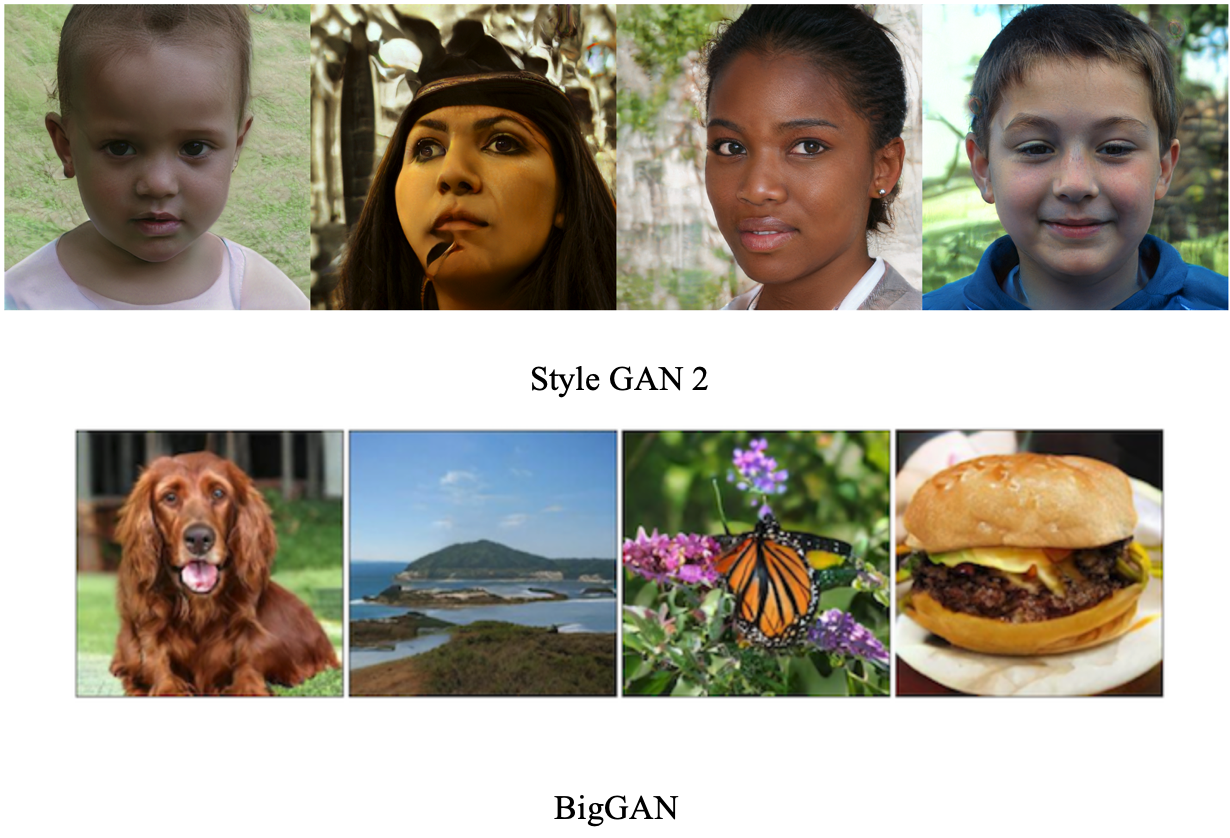

A GAN consists of two neural networks: a generator and a discriminator. It learns by making a generator and a discriminator compete against each other. The generator learns to generate fake images that look real, to fool the discriminator. And the discriminator learns to distinguish between what's real and what's fake. Both models learn from their competition with each other, until the examples produced by the generator are good enough to fool the discriminator. 

## Import Libraries

In [17]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


## Task 2: Load and Preprocess the Data

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

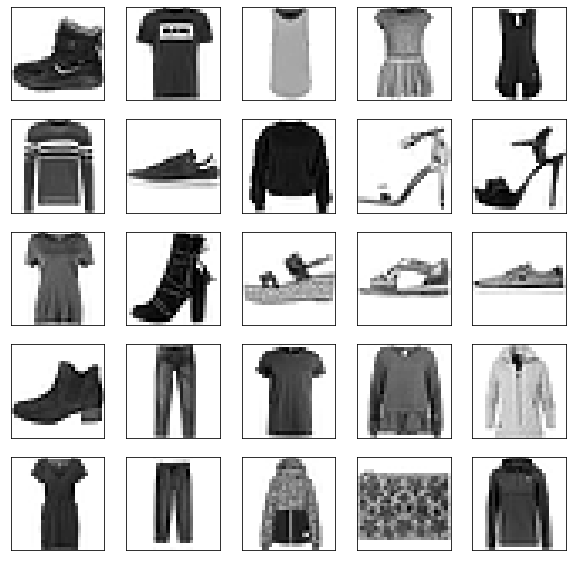

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [20]:
def show(images, n_cols = None):
    n_cols = n_cols or lem(images)
    n_rows = (len(images)-1)//n_cols +1
    if images.shape[-1]==1:
        images = np.squeeze(images, axis = -1)
    plt.figure(figsize = (n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index +1)
        plt.imshow(image, cmap = 'binary')
        plt.axis('off')

## Create Batches of Training Data

In [21]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
#Creates a Dataset that prefetches elements from this dataset

## Build the Generator Network for DCGAN

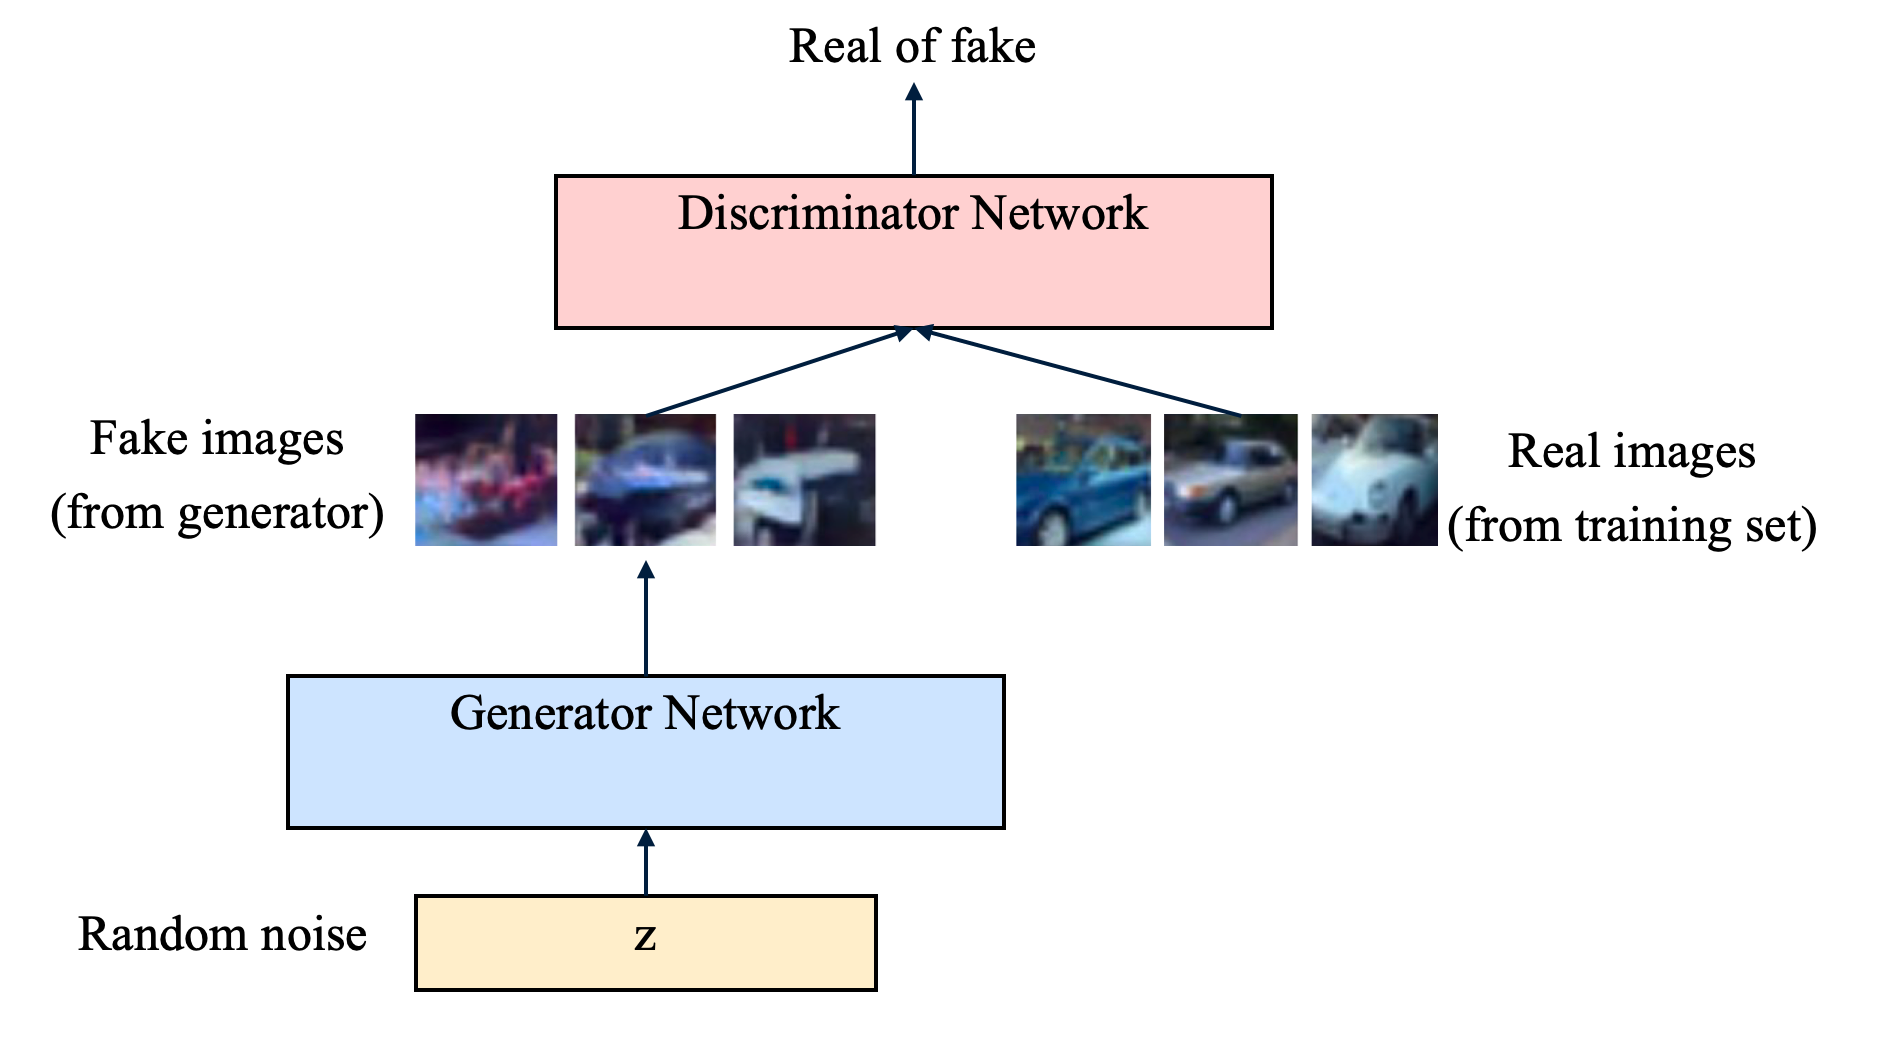

In [22]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

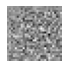

In [23]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

## Build the Discriminator Network for DCGAN

In [24]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.50131196]], shape=(1, 1), dtype=float32)


## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [26]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Task 7: Define Training Procedure

In [27]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [28]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [29]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

##Train DCGAN

In [30]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [31]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

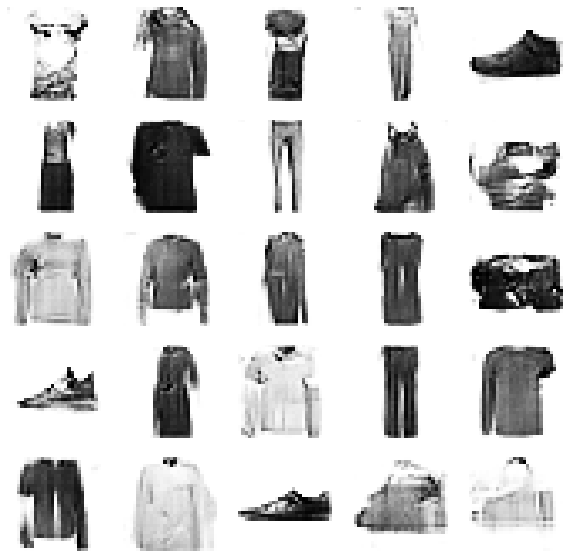

CPU times: user 5min 13s, sys: 17 s, total: 5min 30s
Wall time: 6min 1s


In [32]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Generate Synthetic Images with DCGAN

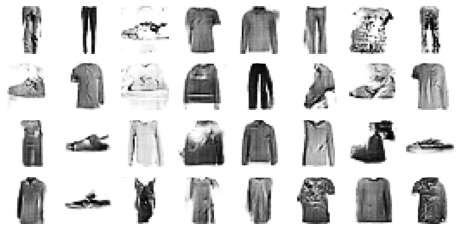

In [34]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)